# **AWS Lambda Performance Analysis**

Consume and parse Locust logs to get the distribution of performance.

Created by Juan Albert Wibowo on Oct 8, 2024

In [2]:
%pip install -q matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


### **Plot Line Graph of Performance Over Time**

_Note_: Ensure that `test_locust_logs.txt` is located in the same directory as your Notebook file.

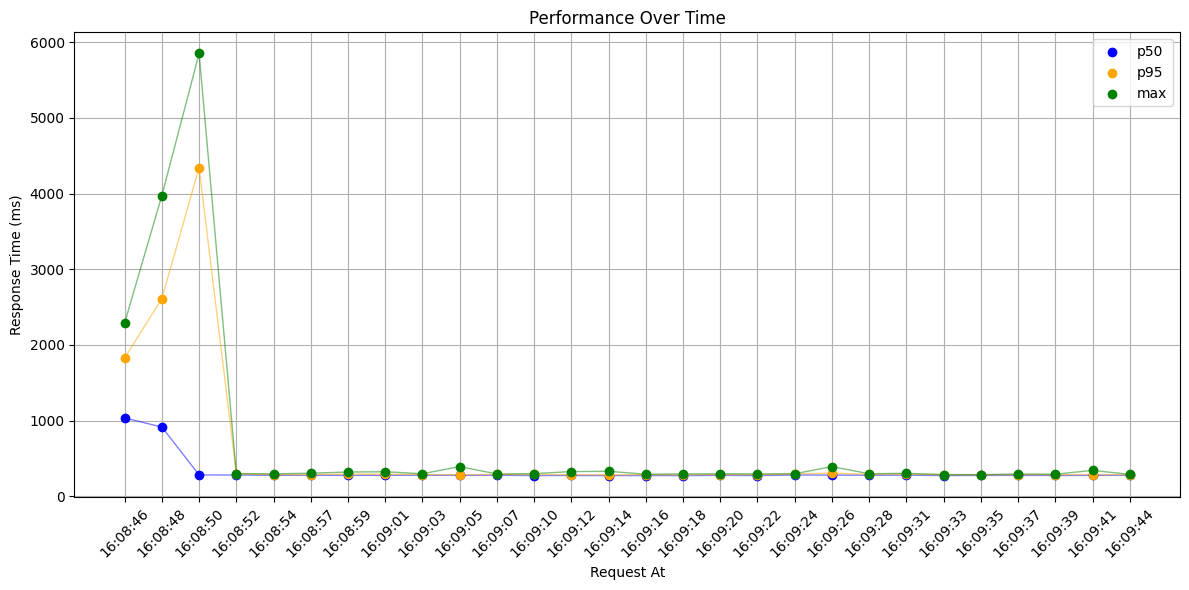

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import re
from datetime import datetime

# Initialize lists for storing data
response_times = []
request_times = []

# Open and read the log file
with open("locust_logs/test_locust_logs.txt", "r") as file:
    for line in file:
        # Regex to capture time and response time
        match = re.search(r"\[(\d{4}-\d{2}-\d{2}) (\d{2}:\d{2}:\d{2},\d{3})\].*Response time: (\d+\.\d+) ms", line)
        if match:
            request_time_str = match.group(2)  # Extract time
            response_time = float(match.group(3))  # Extract response time

            # Convert request time to datetime object
            request_time = datetime.strptime(request_time_str, "%H:%M:%S,%f")

            # Store data
            request_times.append(request_time)
            response_times.append(response_time)

# Convert request_times to a format suitable for plotting (just time)
request_times = [t.strftime("%H:%M:%S") for t in request_times]

# Calculate p50, p95, and max for every 50 response times
step_size = 50  # Change this value to reduce the density
p50_values = []
p95_values = []
max_values = []
time_labels = []

for i in range(0, len(response_times), step_size):
    segment = response_times[i:i + step_size]
    if segment:  # Ensure the segment is not empty
        p50 = np.percentile(segment, 50)
        p95 = np.percentile(segment, 95)
        max_response = max(segment)

        p50_values.append(p50)
        p95_values.append(p95)
        max_values.append(max_response)
        time_labels.append(request_times[i])  # Use the starting time of the segment for x-axis

# Prepare data for plotting
x_indices = np.arange(len(time_labels))

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot p50, p95, and max as points
plt.scatter(x_indices, p50_values, marker='o', color='blue', label='p50', zorder=3)
plt.scatter(x_indices, p95_values, marker='o', color='orange', label='p95', zorder=3)
plt.scatter(x_indices, max_values, marker='o', color='green', label='max', zorder=3)

# Connect points with lines for better visualization
plt.plot(x_indices, p50_values, color='blue', linestyle='-', linewidth=1, alpha=0.5)
plt.plot(x_indices, p95_values, color='orange', linestyle='-', linewidth=1, alpha=0.5)
plt.plot(x_indices, max_values, color='green', linestyle='-', linewidth=1, alpha=0.5)

# Set the x-ticks to be the time labels
plt.xticks(x_indices, time_labels, rotation=45)

# Adding labels and title
plt.title("Performance Over Time")
plt.xlabel("Request At")
plt.ylabel("Response Time (ms)")
plt.grid(True)
plt.legend()  # Add a legend

# Show the plot
plt.tight_layout()
plt.show()


### **Plot Histogram of Request Times During Cold Start and Warm Requests**

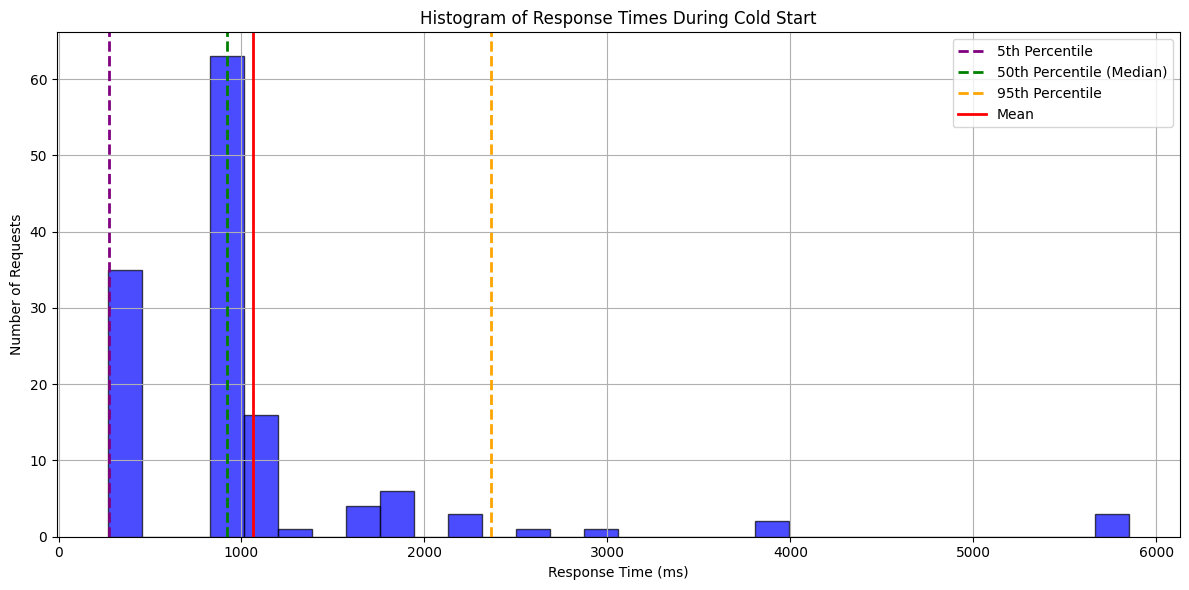

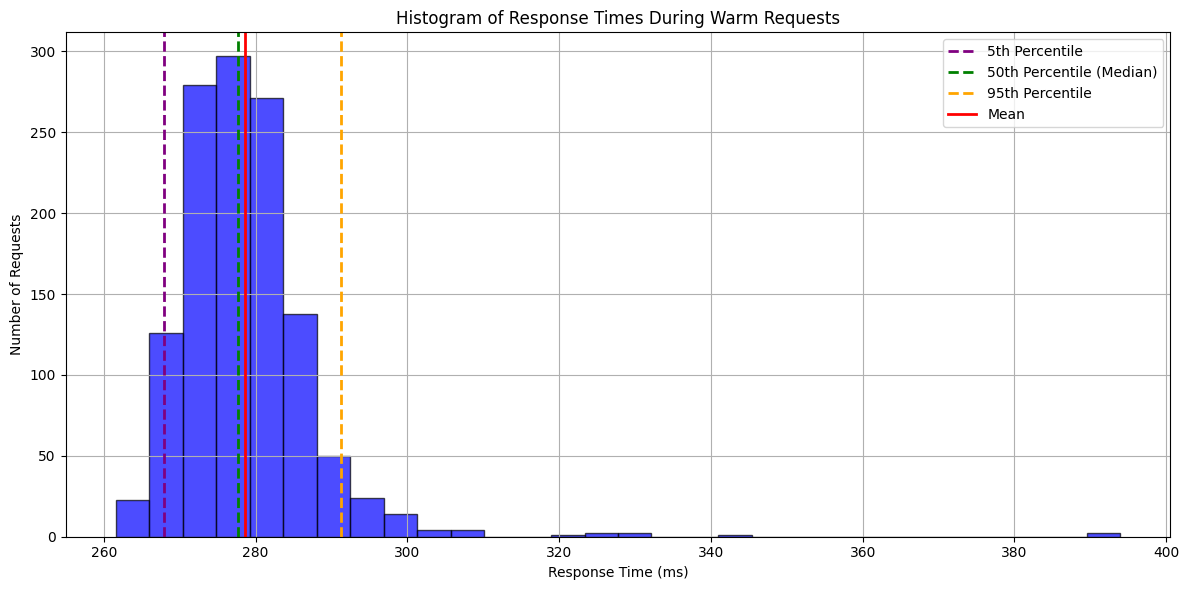

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import re
from datetime import datetime

# Initialize lists for storing data
response_times = []
request_times = []

# Open and read the log file
with open("locust_logs/test_locust_logs.txt", "r") as file:
    for line in file:
        # Regex to capture time and response time
        match = re.search(r"\[(\d{4}-\d{2}-\d{2}) (\d{2}:\d{2}:\d{2},\d{3})\].*Response time: (\d+\.\d+) ms", line)
        if match:
            request_time_str = match.group(2)  # Extract time
            response_time = float(match.group(3))  # Extract response time

            # Convert request time to datetime object
            request_time = datetime.strptime(request_time_str, "%H:%M:%S,%f")

            # Store data
            request_times.append(request_time)
            response_times.append(response_time)

# Specify the cold start end time
cold_start_end_time_str = "16:08:52,262"  # Estimated cold start end time
cold_start_end_time = datetime.strptime(cold_start_end_time_str, "%H:%M:%S,%f")

# Separate cold start and warm request response times
cold_start_response_times = [response_times[i] for i in range(len(request_times)) if request_times[i] <= cold_start_end_time]
warm_response_times = [response_times[i] for i in range(len(request_times)) if request_times[i] > cold_start_end_time]

# Function to plot histogram and metrics
def plot_histogram(response_data, title):
    # Calculate percentiles and mean
    p5 = np.percentile(response_data, 5)
    p50 = np.percentile(response_data, 50)
    p95 = np.percentile(response_data, 95)
    mean_response_time = np.mean(response_data)

    # Create the histogram
    plt.figure(figsize=(12, 6))
    plt.hist(response_data, bins=30, alpha=0.7, color='blue', edgecolor='black')

    # Adding lines for percentiles and mean
    plt.axvline(p5, color='purple', linestyle='--', linewidth=2, label='5th Percentile')
    plt.axvline(p50, color='green', linestyle='--', linewidth=2, label='50th Percentile (Median)')
    plt.axvline(p95, color='orange', linestyle='--', linewidth=2, label='95th Percentile')
    plt.axvline(mean_response_time, color='red', linestyle='-', linewidth=2, label='Mean')

    # Adding labels and title
    plt.title(title)
    plt.xlabel("Response Time (ms)")
    plt.ylabel("Number of Requests")
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot histograms for cold start and warm requests
plot_histogram(cold_start_response_times, "Histogram of Response Times During Cold Start")
plot_histogram(warm_response_times, "Histogram of Response Times During Warm Requests")
